In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [2]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrianed_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

In [4]:
import torch.nn as nn
for parameter in pretrianed_vit.parameters():
    parameter.requires_grad = False

pretrianed_vit.heads = nn.Linear(in_features=768, out_features=2).to(device)

In [5]:
from torchinfo import summary

summary(model=pretrianed_vit,
        input_size=[1,3,224,224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [6]:
### Preparing data for vit model
from pathlib import Path

# Setting up dataset path
data_path = Path('data')
# Setup train val data
train_dir = data_path / 'train'
val_dir = data_path / 'val'
test_dir = data_path / 'test'

train_dir, val_dir, test_dir

(PosixPath('data/train'), PosixPath('data/val'), PosixPath('data/test'))

In [7]:
# Transform the data
from torch.utils.data import DataLoader
from torchvision import transforms


# Data augmentation we will do
vit_transforms = pretrained_vit_weights.transforms()


train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 90)),
    vit_transforms
])


# Implementing test transforms with basic augmentation
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    vit_transforms
])


In [8]:
# Import dataset
from torchvision import datasets

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

class_names = train_data.classes
train_data, val_data, test_data

(Dataset ImageFolder
     Number of datapoints: 101
     Root location: data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomRotation(degrees=[0.0, 90.0], interpolation=nearest, expand=False, fill=0)
                ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            )
            ),
 Dataset ImageFolder
     Number of datapoints: 28
     Root location: data/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ImageClassification(
                crop_size=[224]
                resize_size=[256]

In [9]:
# Turning Dataset into dataloaders
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [10]:

train_dataloader.batch_size

16

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
def plot_random_batch_of_images(dataloader: DataLoader, class_names):
  features_batch, labels_batch = next(iter(dataloader))
  batch_size = dataloader.batch_size
  if batch_size > 4:
    cols = rows = 4
  else:
    cols = rows = int(batch_size/2)
  figure = plt.figure(figsize=(8, 8))
  for i in range(1, cols * rows + 1):
    img, label = features_batch[i-1], labels_batch[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis("Off");
    plt.imshow(img.squeeze().permute(1,2,0))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

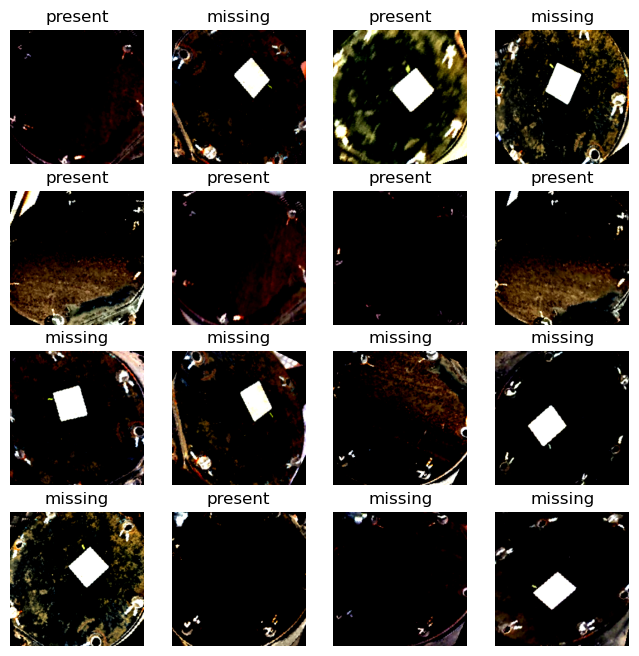

In [12]:
plot_random_batch_of_images(train_dataloader, class_names)

In [13]:
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [14]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(pretrianed_vit.parameters(),
                            lr=1e-3,
                            betas=(0.9,0.999),
                            weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=pretrianed_vit,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        epochs=10,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5915 | train_acc: 0.6411 | test_loss: 0.6378 | test_acc: 0.5938
Epoch: 2 | train_loss: 0.4038 | train_acc: 0.8393 | test_loss: 0.5469 | test_acc: 0.7083
Epoch: 3 | train_loss: 0.3506 | train_acc: 0.8196 | test_loss: 0.5363 | test_acc: 0.7812
Epoch: 4 | train_loss: 0.4060 | train_acc: 0.8125 | test_loss: 0.4805 | test_acc: 0.8021
Epoch: 5 | train_loss: 0.2662 | train_acc: 0.9107 | test_loss: 0.5119 | test_acc: 0.7500
Epoch: 6 | train_loss: 0.3225 | train_acc: 0.8286 | test_loss: 0.4643 | test_acc: 0.7917
Epoch: 7 | train_loss: 0.2625 | train_acc: 0.9196 | test_loss: 0.4767 | test_acc: 0.8125
Epoch: 8 | train_loss: 0.2176 | train_acc: 0.9161 | test_loss: 0.4052 | test_acc: 0.8750
Epoch: 9 | train_loss: 0.2400 | train_acc: 0.9196 | test_loss: 0.4733 | test_acc: 0.7812
Epoch: 10 | train_loss: 0.2565 | train_acc: 0.9071 | test_loss: 0.4301 | test_acc: 0.9271


In [15]:
import torchvision.utils as utils
from torchvision.utils import save_image
from tqdm.auto import tqdm
# Recreate an instance of TinyVGG

pretrianed_vit.eval()
y_preds = []
val_loss = 0
val_acc = 0
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrianed_vit(X)
    if isinstance(y_logit, list):
      y_logit = y_logit[0]
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    
    loss = loss_fn(y_logit, y)
            
    val_loss += loss.item()
    
    val_acc += ((y_pred == y).sum().item()/len(y_pred))
    
  val_loss /= len(test_dataloader)
  val_acc /= len(test_dataloader)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

print(f"Test Acc {val_acc:.4f} | Test Loss {val_loss:.4f}")

Making predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Test Acc 0.8750 | Test Loss 0.4122


In [16]:
class_names = train_data.classes
class_names

['missing', 'present']

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x7fb8daddf2e0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/multiprocessing/connection.py", line 360, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    reader_close()
  File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/multiprocessing/connection.py", line 360, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Tra

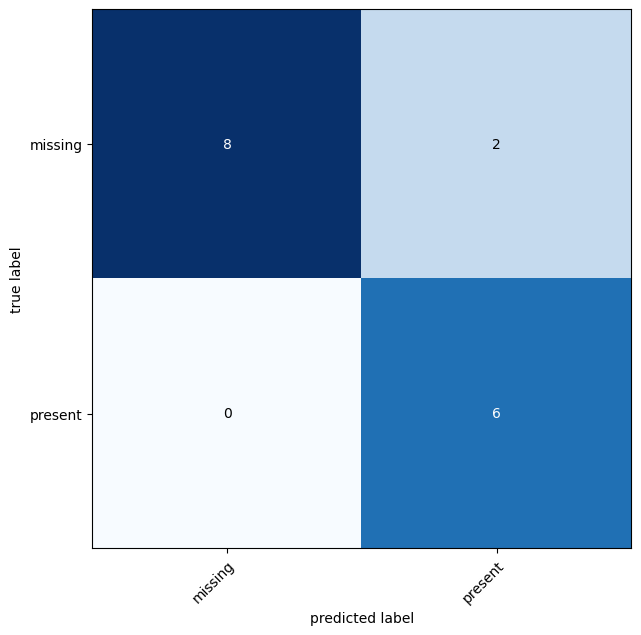

In [17]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='binary')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);